# Limestone Data Challenge

Right now, we have used behavorial context clustering which only takes into account the previous moves of the player and the opponent. 
We also planned to implement the following, but could not due to lack of time:
Train a neural network (Can use RNN and regular NN, RNN trains slower but is will require less dimensions of sequential data: and also probably represents the problem more accurately since the games are a sequence; while NN trains faster but dimensionality is very high ) to fit each players games. 

The input would be the typical input to a strategy function (moves of self and opponent till the current turn (padded by 0s to go upto length 80) and expect the output to be either 0 or 1. Then we can use the weights of this network as "points" representing the strategy and cluster these using KMeans as we have done now too. I think this would provide more accurate clusters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from enum import Enum
class act(Enum):
    TRUST = -1
    CHEAT = 1

In [2]:
data = pd.read_csv('input_game.csv')
data.p1_action.apply(lambda x: act[x])
data.p2_action.apply(lambda x: act[x])
print("Maximum number of turns in the data", data.turn.max())
data.head()

Maximum number of turns in the data 80


,game_id,p1_id,p2_id,p1_action,p2_action,turn
0,0,174,125,TRUST,CHEAT,1
1,0,174,125,CHEAT,TRUST,2
2,0,174,125,TRUST,TRUST,3
3,0,174,125,TRUST,TRUST,4
4,0,174,125,TRUST,TRUST,5


In [3]:
class Game():
    def __init__(self, p1, p2, gid):
        self.gid = gid
        self.p1 = p1
        self.p2 = p2
        self.list_p1 = []
        self.list_p2 = []
    
    def add_turn(self, p1_act, p2_act):
        self.list_p1.append(p1_act)
        self.list_p2.append(p2_act)

player_ids1 = data['p1_id'].unique()
player_ids2 = data['p2_id'].unique()
player_ids = np.concatenate((player_ids1, player_ids2))
player_ids = np.unique(player_ids)

games = {} #dict mapping game_id to Game object
for idx, row in data.iterrows():
    p1 = row['p1_id']
    p2 = row['p2_id']
    gid = row['game_id']
    game = Game(p1, p2, gid)
    if gid not in games:
        games[gid] = game
    games[gid].add_turn(act[row['p1_action']], act[row['p2_action']])

player_games = {} #dict mapping player_id to list of game_ids
for gid, game in games.items():
    if game.p1 not in player_games:
        player_games[game.p1] = []
    if game.p2 not in player_games:
        player_games[game.p2] = []
    player_games[game.p1].append(games[gid])
    player_games[game.p2].append(games[gid])


In [4]:
def encode_player(p_id, p_games):
    #count (TT, CT, TC, CC)
    p_count = [0, 0, 0, 0]
    for game in p_games:
        # if game.p1 == p_id:
        p1_count = [0, 0, 0, 0]
        p2_count = [0, 0, 0, 0]
        p1 = game.p1
        p2 = game.p2
        p1_actions = game.list_p1
        p2_actions = game.list_p2
        for i in range(0,len(p1_actions)):
            if p1_actions[i] == act.TRUST and p2_actions[i] == act.TRUST:
                p1_count[0] += 1
                p2_count[0] += 1
            elif p1_actions[i] == act.CHEAT and p2_actions[i] == act.TRUST:
                p1_count[1] += 1
                p2_count[2] += 1
            elif p1_actions[i] == act.TRUST and p2_actions[i] == act.CHEAT:
                p1_count[2] += 1
                p2_count[1] += 1
            elif p1_actions[i] == act.CHEAT and p2_actions[i] == act.CHEAT:
                p1_count[3] += 1
                p2_count[3] += 1
        if p1 == p_id:
            p_count = [x + y for x, y in zip(p_count, p1_count)]
        else:
            p_count = [x + y for x, y in zip(p_count, p2_count)]
    raw = np.array(p_count)
    return raw

encode_player(1, player_games[1])

array([792, 297, 311, 605])

In [5]:
def encode_behavioral_contextual_player(p_id, p_games):
    #count (TT(C), CT(C), TC(C), CC(C))
    p_count = [0, 0, 0, 0]
    for game in p_games:
        # if game.p1 == p_id:
        p1_count = [0, 0, 0, 0]
        p2_count = [0, 0, 0, 0]
        p1 = game.p1
        p2 = game.p2
        p1_actions = game.list_p1
        p2_actions = game.list_p2
        for i in range(1,len(p1_actions)):
            if p1_actions[i-1] == act.TRUST and p2_actions[i-1] == act.TRUST and p1_actions[i] == act.CHEAT:
                p1_count[0] += 1
                p2_count[0] += 1
            elif p1_actions[i-1] == act.CHEAT and p2_actions[i-1] == act.TRUST and p1_actions[i] == act.CHEAT:
                p1_count[1] += 1
                p2_count[2] += 1
            elif p1_actions[i-1] == act.TRUST and p2_actions[i-1] == act.CHEAT and p1_actions[i] == act.CHEAT:
                p1_count[2] += 1
                p2_count[1] += 1
            elif p1_actions[i-1] == act.CHEAT and p2_actions[i-1] == act.CHEAT and p1_actions[i] == act.CHEAT:
                p1_count[3] += 1
                p2_count[3] += 1
        if p1 == p_id:
            p_count = [x + y for x, y in zip(p_count, p1_count)]
        else:
            p_count = [x + y for x, y in zip(p_count, p2_count)]
    raw = np.array(p_count)
    counts = encode_player(p_id, p_games)
    return raw/counts

print(encode_behavioral_contextual_player(1, player_games[1]))

[0.08585859 0.45117845 0.53376206 0.75702479]


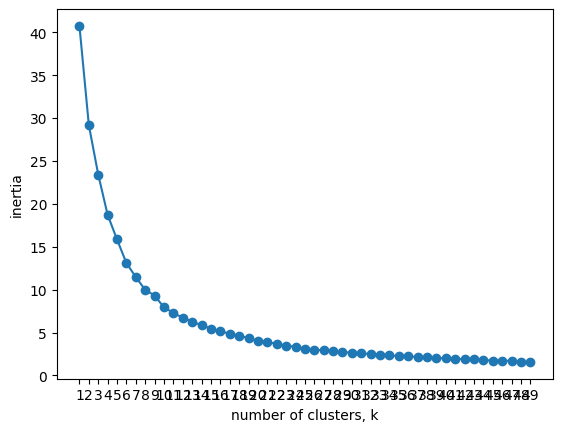

In [6]:
#clustering encoded players using sklearn K means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# scaler = StandardScaler()
X = np.array([encode_behavioral_contextual_player(p_id, player_games[p_id]) for p_id in player_ids])

#compute optimal # clusters using elbow method
ks = range(1, 50)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertias.append(model.inertia_)
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [7]:
# find out optimal number of clusters
from kneed import KneeLocator
kl = KneeLocator(ks, inertias, curve='convex', direction='decreasing')
print("Optimal number of clusters", kl.elbow)
N = kl.elbow

Optimal number of clusters 10


labels
0    13
1    17
2    19
3    41
4    18
5    19
6    22
7     9
8    12
9    31
Name: pids, dtype: int64


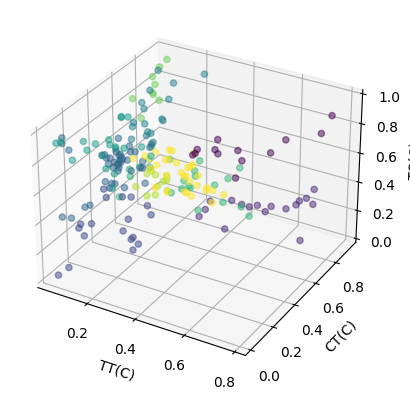

[[1, 2, 3, 10, 14, 20, 30, 34, 36, 37, 42, 51, 53, 55, 56, 65, 67, 77, 79, 85, 93, 100, 112, 118, 126, 138, 141, 146, 149, 150, 152, 159, 161, 168, 174, 177, 179, 180, 188, 190, 200], [4, 15, 21, 33, 108, 110, 111, 115, 136, 140, 155, 158, 172], [5, 11, 27, 29, 41, 59, 62, 75, 76, 84, 87, 91, 109, 113, 117, 130, 132, 135, 143, 153, 164, 182], [6, 8, 31, 43, 61, 95, 99, 104, 121, 133, 137, 139, 175, 178, 186, 192, 193, 194, 196], [7, 39, 58, 73, 88, 89, 125, 144, 157, 162, 183, 185], [9, 12, 13, 35, 46, 60, 69, 74, 80, 82, 86, 101, 103, 122, 154, 171, 176, 181, 199], [16, 24, 32, 50, 71, 72, 78, 81, 94, 114, 116, 142, 145, 156, 160, 166, 187], [17, 19, 22, 23, 38, 45, 57, 64, 92, 96, 97, 105, 131, 148, 167, 169, 189, 197], [18, 25, 26, 28, 40, 44, 48, 49, 54, 66, 68, 83, 90, 98, 102, 106, 119, 120, 123, 124, 127, 128, 129, 147, 151, 163, 170, 173, 184, 191, 198], [47, 52, 63, 70, 107, 134, 165, 195, 201]]


In [8]:
#group pids label wise
model = KMeans(n_clusters=N)
model.fit(X)
labels = model.predict(X)
df = pd.DataFrame({'labels': labels, 'pids': player_ids})
print(df.groupby('labels').pids.count())
strategy_groupings = [[] for i in range(N)]
for i in range(len(labels)):
    strategy_groupings[labels[i]].append(player_ids[i])

#plot clusters in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, alpha=0.5)
ax.set_xlabel('TT(C)')
ax.set_ylabel('CT(C)')
ax.set_zlabel('TC(C)')
plt.show()

# plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5)
# plt.xlabel('TT(C)')
# plt.ylabel('CT(C)')
# plt.show()

strategy_groupings.sort()
print(strategy_groupings)

A four tuple is defined as: (Pr(C|TT), Pr(C|CT), Pr(C|TC), Pr(C|CC)) where Pr(XY(C)) represents probability of cheating when my and opponents last moves are X and Y.

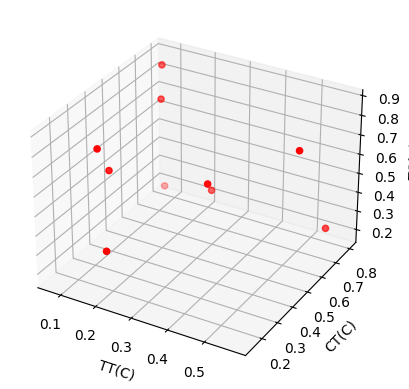

[[0.5509468  0.56797015 0.77731944 0.75983451]
 [0.57263181 0.71260509 0.28508336 0.25028342]
 [0.21163529 0.14407695 0.38835237 0.19274239]
 [0.13088542 0.33178689 0.62213582 0.75885053]
 [0.12420429 0.66551787 0.76420693 0.80037885]
 [0.13144207 0.26658453 0.77685947 0.28888168]
 [0.27780375 0.64655389 0.37500743 0.73801151]
 [0.09208418 0.74217472 0.87851    0.20698578]
 [0.07052092 0.79810851 0.180999   0.87826089]
 [0.36435337 0.42339461 0.61228279 0.51884543]]


In [9]:
#create a list of centroids for each cluster
centroids = model.cluster_centers_
#plot centroids in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red')
ax.set_xlabel('TT(C)')
ax.set_ylabel('CT(C)')
ax.set_zlabel('TC(C)')
plt.show()

print(centroids)

High values of Pr(C|TC) and Pr(C|CC) indicates that the strategy is similar to a "tit-for-tat" strategy which mirrors the opponents last move. This strategy is retaliatory and "nice"(i.e., doesnt defect) at the same time. 

Similar interpretations can be carried out for other strategies.

### Input Encoding

In [14]:
#make dataset for each strategy (all games of all players using that strategy)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

models = []
train_accuracies = []
for i in range(N):
    strat_inputs = []
    strat_outputs = []
    print("Strategy", i)
    for p in strategy_groupings[i]:
        games = player_games[p]
        for g in games:
            my_moves_yet = []
            opp_moves_yet = []
            for turn in range(len(g.list_p1)-1):
                input_mymoves_yet = my_moves_yet + [0 for _ in range(80-turn)]
                input_oppmoves_yet = opp_moves_yet + [0 for _ in range(80-turn)]
                net_input = input_mymoves_yet + input_oppmoves_yet

                strat_inputs.append(net_input)
                if p == g.p1:
                    my_moves_yet.append(g.list_p1[turn].value)

                    opp_moves_yet.append(g.list_p2[turn].value)
                else:
                    my_moves_yet.append(g.list_p2[turn].value)
                    opp_moves_yet.append(g.list_p1[turn].value)
                strat_outputs.append(my_moves_yet[-1])
    strat_inputs = np.array(strat_inputs)
    strat_outputs = np.array(strat_outputs)
    print(strat_inputs.shape)
    print(strat_outputs.shape)
    #train a neural network on this dataset which whill represent the strategy
    X_train, X_test, y_train, y_test = train_test_split(strat_inputs, strat_outputs, test_size=0.2, random_state=42)
    #also show training progress
    model = MLPClassifier(hidden_layer_sizes=(80, 20), max_iter=5, verbose=True)
    model.fit(X_train, y_train)
    models.append(model)
    train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    print("Train accuracy", train_accuracies[-1])
    print("Test accuracy", accuracy_score(y_test, model.predict(X_test)))


Strategy 0
(74576, 160)
(74576,)
Iteration 1, loss = 0.52118155
Iteration 2, loss = 0.47869665
Iteration 3, loss = 0.45830634
Iteration 4, loss = 0.44303705
Iteration 5, loss = 0.43188319
Train accuracy 0.8037546094535702
Test accuracy 0.7817109144542773
Strategy 1


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(23368, 160)
(23368,)
Iteration 1, loss = 0.29699172
Iteration 2, loss = 0.25885275
Iteration 3, loss = 0.24941582
Iteration 4, loss = 0.24363745
Iteration 5, loss = 0.24004435
Train accuracy 0.9262330159409436
Test accuracy 0.9229781771501926
Strategy 2


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(38392, 160)
(38392,)
Iteration 1, loss = 0.56017272
Iteration 2, loss = 0.52420097
Iteration 3, loss = 0.50705121
Iteration 4, loss = 0.49582088
Iteration 5, loss = 0.48592707
Train accuracy 0.7587666460456485
Test accuracy 0.7007422841515822
Strategy 3


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(34336, 160)
(34336,)
Iteration 1, loss = 0.45883977
Iteration 2, loss = 0.40664701
Iteration 3, loss = 0.39793563
Iteration 4, loss = 0.39263607
Iteration 5, loss = 0.38678690
Train accuracy 0.8431265472549876
Test accuracy 0.836924868957484
Strategy 4


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(20312, 160)
(20312,)
Iteration 1, loss = 0.48461484
Iteration 2, loss = 0.40429832
Iteration 3, loss = 0.36353036
Iteration 4, loss = 0.33314070
Iteration 5, loss = 0.30783922
Train accuracy 0.8908240507108129
Test accuracy 0.8759537287718435
Strategy 5


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(34077, 160)
(34077,)
Iteration 1, loss = 0.53187807
Iteration 2, loss = 0.50181422
Iteration 3, loss = 0.48948719
Iteration 4, loss = 0.48115323
Iteration 5, loss = 0.47495162
Train accuracy 0.768020248706944
Test accuracy 0.7394366197183099
Strategy 6


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(28215, 160)
(28215,)
Iteration 1, loss = 0.60506735
Iteration 2, loss = 0.57508694
Iteration 3, loss = 0.55763895
Iteration 4, loss = 0.54156907
Iteration 5, loss = 0.52565755
Train accuracy 0.759525075314549
Test accuracy 0.7309941520467836
Strategy 7


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(31486, 160)
(31486,)
Iteration 1, loss = 0.42927697
Iteration 2, loss = 0.36370413
Iteration 3, loss = 0.34046231
Iteration 4, loss = 0.32409021
Iteration 5, loss = 0.31120832
Train accuracy 0.8850246148959822
Test accuracy 0.8763099396633852
Strategy 8


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(54578, 160)
(54578,)
Iteration 1, loss = 0.65114139
Iteration 2, loss = 0.63348630
Iteration 3, loss = 0.62615267
Iteration 4, loss = 0.62027786
Iteration 5, loss = 0.61543812
Train accuracy 0.6505199028903852
Test accuracy 0.6018688164162697
Strategy 9


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(15442, 160)
(15442,)
Iteration 1, loss = 0.65677823
Iteration 2, loss = 0.62924182
Iteration 3, loss = 0.61706989
Iteration 4, loss = 0.60686769
Iteration 5, loss = 0.59701046
Train accuracy 0.6853395936209827
Test accuracy 0.6280349627711234


/Users/samarth/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
class Strategy():
    def __init__(self, strat_id, model):
        self.strat_id = strat_id
        self.model = model

strats = []
for i in range(N):
    strats.append(Strategy(i, models[i]))

strat_scores = [0 for _ in range(N)]
def encode(act_id):
    if act_id == act.TRUST.value:
        return act.TRUST
    else:
        return act.CHEAT

for i in range(N):
    for j in range(N):
        #1 game for each strategy pair
        st1 = strats[i]
        st2 = strats[j]
        game = Game(0, 0, 0)
        my_moves_yet = []
        opp_moves_yet = []
        for turn in range(np.random.randint(80)):
            input_mymoves_yet = my_moves_yet + [0 for _ in range(80-turn)]
            input_oppmoves_yet = opp_moves_yet + [0 for _ in range(80-turn)]
            net_input = input_mymoves_yet + input_oppmoves_yet
            my_act = st1.model.predict(np.array([net_input]))
            opp_act = st2.model.predict(np.array([net_input]))
            my_moves_yet.append(my_act[0])
            opp_moves_yet.append(opp_act[0])
            game.add_turn(encode(my_act[0]), encode(opp_act[0]))
        
        #calculate scores for both strategies
        p1_score = 0
        p2_score = 0
        for turn in range(len(game.list_p1)):
            if game.list_p1[turn] == act.TRUST and game.list_p2[turn] == act.TRUST:
                p1_score += 2
                p2_score += 2
            elif game.list_p1[turn] == act.CHEAT and game.list_p2[turn] == act.TRUST:
                p1_score += 3
                p2_score -= 1
            elif game.list_p1[turn] == act.TRUST and game.list_p2[turn] == act.CHEAT:
                p2_score += 3
                p1_score -= 1
            elif game.list_p1[turn] == act.CHEAT and game.list_p2[turn] == act.CHEAT:
                p1_score += 0
                p2_score += 0
        strat_scores[i] += p1_score
        strat_scores[j] += p2_score
        


In [26]:
for i in range(N):
    print("Strategy", i, ": score = ", strat_scores[i])

strat_scores = list(zip(strat_scores, range(N)))
        

Strategy 0 : score =  838
Strategy 1 : score =  425
Strategy 2 : score =  770
Strategy 3 : score =  1558
Strategy 4 : score =  1193
Strategy 5 : score =  1111
Strategy 6 : score =  996
Strategy 7 : score =  896
Strategy 8 : score =  696
Strategy 9 : score =  955
[(838, 0), (425, 1), (770, 2), (1558, 3), (1193, 4), (1111, 5), (996, 6), (896, 7), (696, 8), (955, 9)]


In [29]:
strat_scores.sort(key=lambda x: x[0], reverse=True)
print(strat_scores)
for i in range(N):
    print("Strategy", strat_scores[i][1], ": score = ", strat_scores[i][0])

[(1558, 3), (1193, 4), (1111, 5), (996, 6), (955, 9), (896, 7), (838, 0), (770, 2), (696, 8), (425, 1)]
Strategy 3 : score =  1558
Strategy 4 : score =  1193
Strategy 5 : score =  1111
Strategy 6 : score =  996
Strategy 9 : score =  955
Strategy 7 : score =  896
Strategy 0 : score =  838
Strategy 2 : score =  770
Strategy 8 : score =  696
Strategy 1 : score =  425
